In [3]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from keras.models import Sequential, Model ,model_from_json
from keras.preprocessing.image import load_img ,img_to_array
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [7]:
BASE_DIR = r'C:\AgeDataset\UTKFace'

In [8]:
#[age] is an integer from 0 to 116, indicating the age
#[gender] is either 0 (male) or 1 (female)
#[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [9]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

image  age  gender
0  C:\AgeDataset\UTKFace\100_0_0_2017011221350090...  100       0
1  C:\AgeDataset\UTKFace\100_0_0_2017011221524034...  100       0
2  C:\AgeDataset\UTKFace\100_1_0_2017011018372639...  100       1
3  C:\AgeDataset\UTKFace\100_1_0_2017011221300198...  100       1
4  C:\AgeDataset\UTKFace\100_1_0_2017011221330369...  100       1

In [10]:
gender_dict = {0:'Male', 1:'Female'}

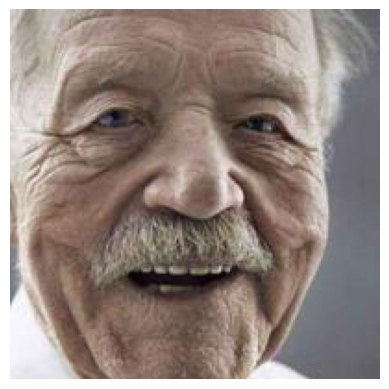

In [13]:
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

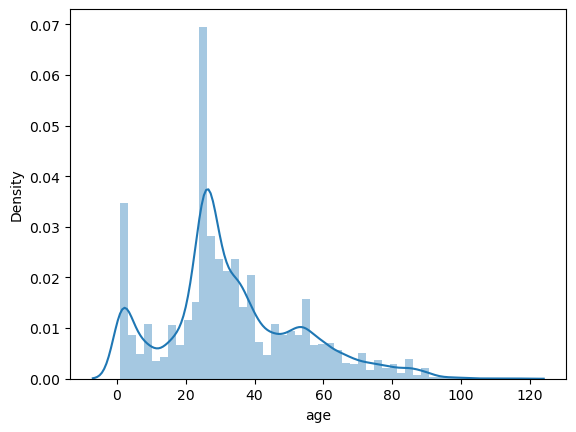

In [15]:
sns.distplot(df['age']);

<AxesSubplot:xlabel='gender', ylabel='count'>

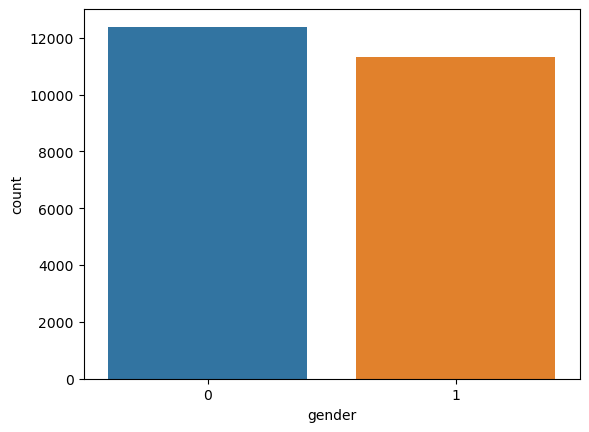

In [16]:
sns.countplot(df['gender'])

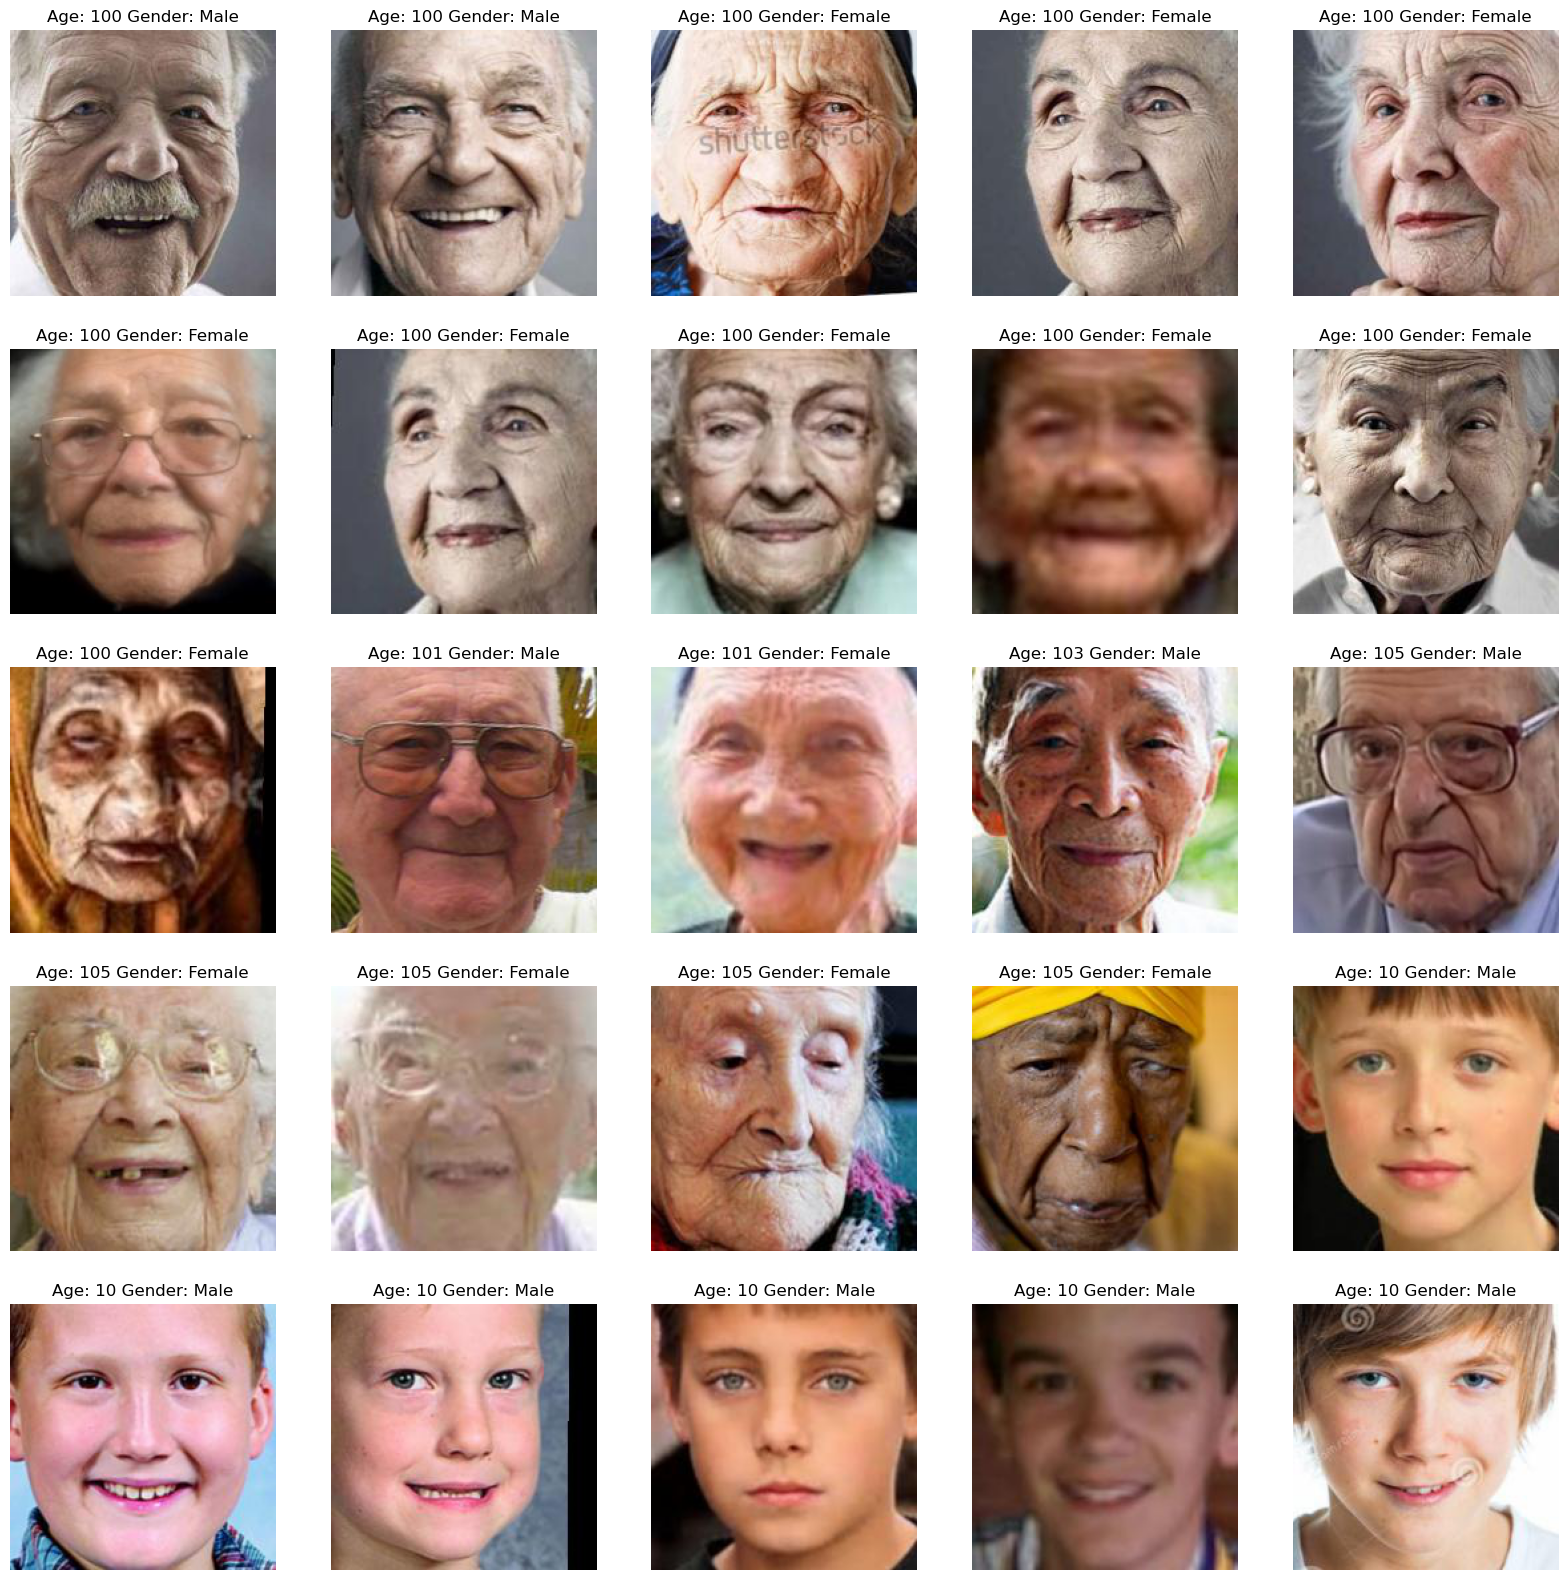

In [17]:
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [23]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [24]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [25]:
X.shape

(23708, 128, 128, 1)

In [26]:
X = X/255.0

In [27]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [28]:
input_shape = (128, 128, 1)

In [29]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [30]:
from tensorflow.keras.utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [31]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30


593/593 [==============================] - 139s 229ms/step - loss: 10.7587 - gender_out_loss: 0.6531 - age_out_loss: 10.1057 - gender_out_accuracy: 0.5965 - age_out_accuracy: 0.0592 - val_loss: 32.3360 - val_gender_out_loss: 0.5121 - val_age_out_loss: 31.8239 - val_gender_out_accuracy: 0.7594 - val_age_out_accuracy: 0.0000e+00
Epoch 2/30
593/593 [==============================] - 128s 217ms/step - loss: 8.0760 - gender_out_loss: 0.4155 - age_out_loss: 7.6605 - gender_out_accuracy: 0.8088 - age_out_accuracy: 0.0469 - val_loss: 32.4001 - val_gender_out_loss: 0.4676 - val_age_out_loss: 31.9324 - val_gender_out_accuracy: 0.7817 - val_age_out_accuracy: 0.0000e+00
Epoch 3/30
593/593 [==============================] - 122s 206ms/step - loss: 7.1250 - gender_out_loss: 0.3452 - age_out_loss: 6.7798 - gender_out_accuracy: 0.8465 - age_out_accuracy: 0.0255 - val_loss: 24.8747 - val_gender_out_loss: 0.4358 - val_age_out_loss: 24.4388 - val_gender_out_accuracy: 0.7976 - val_age_out_acc

Epoch 24/30
593/593 [==============================] - 125s 211ms/step - loss: 3.5722 - gender_out_loss: 0.1129 - age_out_loss: 3.4593 - gender_out_accuracy: 0.9528 - age_out_accuracy: 0.0038 - val_loss: 18.3561 - val_gender_out_loss: 0.6213 - val_age_out_loss: 17.7348 - val_gender_out_accuracy: 0.8446 - val_age_out_accuracy: 0.0000e+00
Epoch 25/30
593/593 [==============================] - 121s 204ms/step - loss: 3.5052 - gender_out_loss: 0.1087 - age_out_loss: 3.3965 - gender_out_accuracy: 0.9575 - age_out_accuracy: 0.0041 - val_loss: 18.7185 - val_gender_out_loss: 0.6405 - val_age_out_loss: 18.0780 - val_gender_out_accuracy: 0.8414 - val_age_out_accuracy: 0.0000e+00
Epoch 26/30
593/593 [==============================] - 121s 204ms/step - loss: 3.4574 - gender_out_loss: 0.1000 - age_out_loss: 3.3575 - gender_out_accuracy: 0.9590 - age_out_accuracy: 0.0037 - val_loss: 18.1717 - val_gender_out_loss: 0.6833 - val_age_out_loss: 17.4884 - val_gender_out_accuracy: 0.8402 - val_age_out_accu

In [33]:
model_json = model.to_json()
with open('Age_model.json','w') as json_file:
    json_file.write(model_json)

In [34]:
model.save_weights('Age_model.h5')

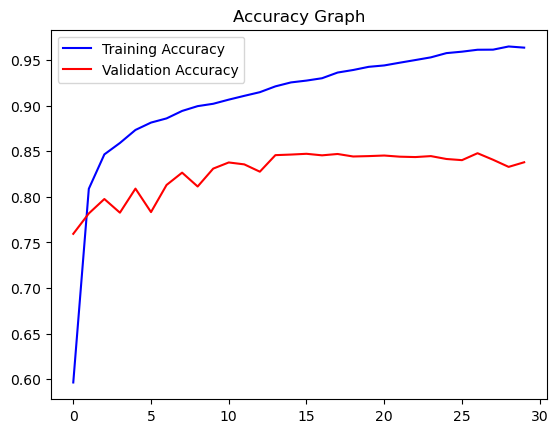

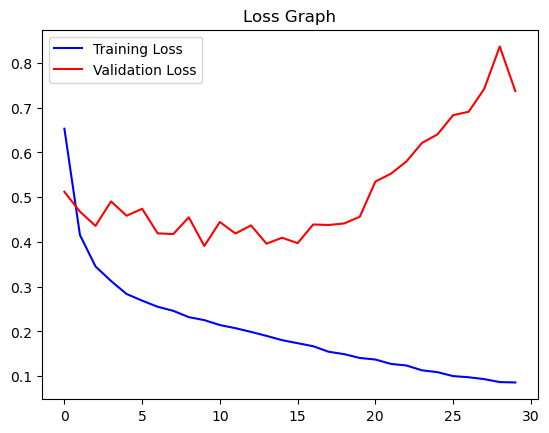

In [35]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

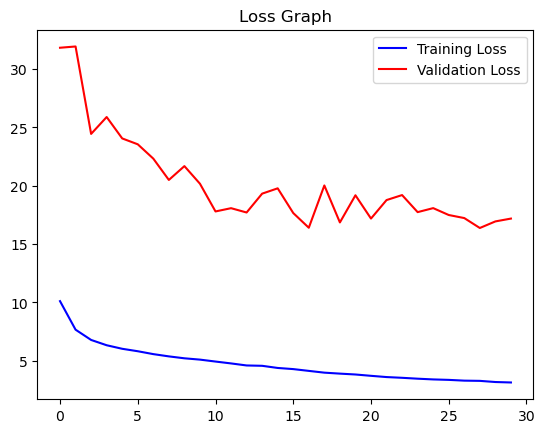

In [36]:
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Male Original Age: 10
1/1 [==============================] - 0s 222ms/step
Predicted Gender: Male Predicted Age: 11


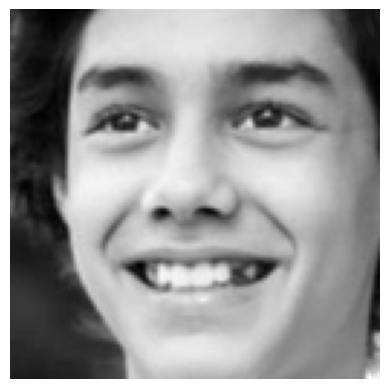

In [37]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 21
1/1 [==============================] - 0s 54ms/step
Predicted Gender: Male Predicted Age: 23


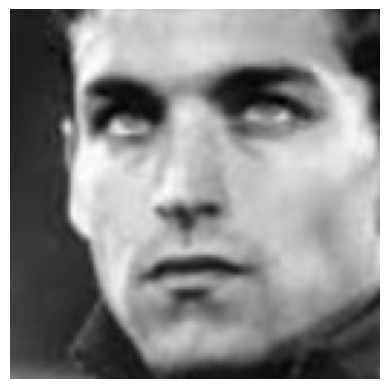

In [38]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 29
1/1 [==============================] - 0s 43ms/step
Predicted Gender: Female Predicted Age: 29


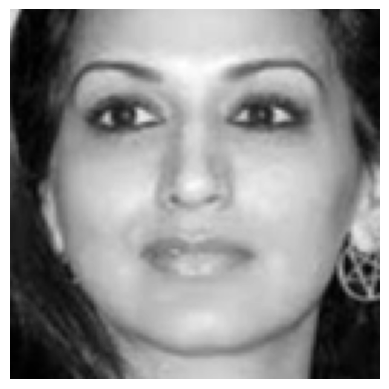

In [39]:
image_index = 10000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

C:\Users\Hassa\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


C:\Users\Hassa\anaconda3\lib\site-packages\keras\src\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


1/1 [==============================] - 0s 332ms/step


C:\Users\Hassa\AppData\Local\Temp\ipykernel_4164\2238435844.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  age_prediction = int(predictions[1][0])


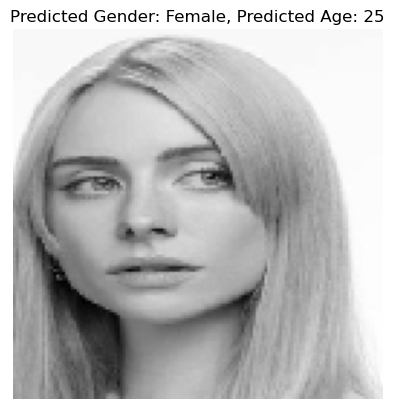

In [1]:
json_file = open('Age_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights('Age_model.h5')

image_path = r'Desktop\2024-06-25 13_50_03-maddie phillips - Google Search.png'  

img = load_img(image_path, grayscale=True, target_size=(128, 128))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  

predictions = loaded_model.predict(img_array)
gender_prediction = 'Female' if predictions[0][0] > 0.5 else 'Male'
age_prediction = int(predictions[1][0])

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title(f'Predicted Gender: {gender_prediction}, Predicted Age: {age_prediction}')
plt.show()


1/1 [==============================] - 0s 35ms/step


C:\Users\Hassa\AppData\Local\Temp\ipykernel_4164\766390851.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  age_prediction = int(predictions[1][0])


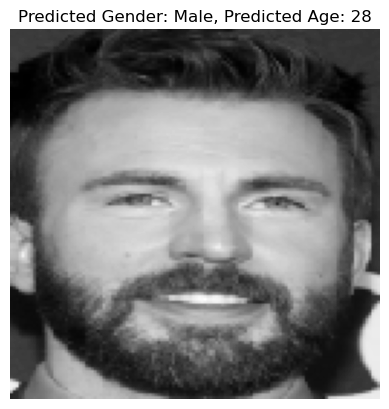

In [2]:
image_path = r'Desktop\2024-06-25 13_52_34-chris evans - Google Search.png' 

img = load_img(image_path, grayscale=True, target_size=(128, 128))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  

predictions = loaded_model.predict(img_array)
gender_prediction = 'Female' if predictions[0][0] > 0.5 else 'Male'
age_prediction = int(predictions[1][0])

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title(f'Predicted Gender: {gender_prediction}, Predicted Age: {age_prediction}')
plt.show()
